In [1]:
library(AppliedPredictiveModeling)
set.seed(975)
trn <- quadBoundaryFunc(500)
vld <- quadBoundaryFunc(1000)
head(trn)

X1,X2,prob,class
2.4685709,2.28742015,0.9647251,Class1
-0.1889407,-1.63949455,0.9913938,Class1
-1.9101460,-2.89194964,1.0000000,Class1
0.3481279,0.06707434,0.1529697,Class1
0.1401153,0.86900555,0.5563062,Class1
0.7717148,-0.91504835,0.2713248,Class2


Warning message in barchart.table(table(x), data, ...):
"explicit 'data' specification ignored"

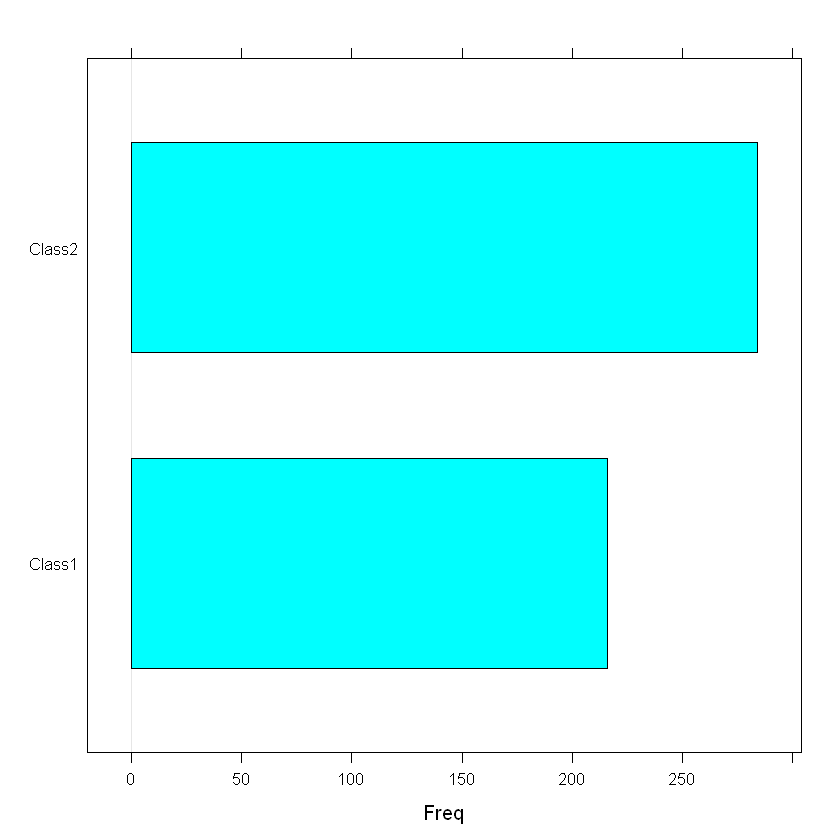

In [2]:
# table(trn$class)
library(lattice)
barchart(trn$class,data=trn)

In [11]:
library(randomForest)
fit_rf <- randomForest(class~X1+X2,data=trn,ntree=2000)
fit_rf

library(MASS)
fit_qda <- qda(class~X1+X2,data=trn)
fit_qda


Call:
 randomForest(formula = class ~ X1 + X2, data = trn, ntree = 2000) 
               Type of random forest: classification
                     Number of trees: 2000
No. of variables tried at each split: 1

        OOB estimate of  error rate: 15.6%
Confusion matrix:
       Class1 Class2 class.error
Class1    174     42   0.1944444
Class2     36    248   0.1267606

Call:
qda(class ~ X1 + X2, data = trn)

Prior probabilities of groups:
Class1 Class2 
 0.432  0.568 

Group means:
              X1          X2
Class1 0.5881427 -0.05429687
Class2 1.2342071  0.11753625

```r

library(AppliedPredictiveModeling)

### Simulate some two class data with two predictors
set.seed(975)
training <- quadBoundaryFunc(500)
testing <- quadBoundaryFunc(1000)
testing$class2 <- ifelse(testing$class == "Class1", 1, 0)
testing$ID <- 1:nrow(testing)

### Fit models
library(MASS)
qdaFit <- qda(class ~ X1 + X2, data = training)
library(randomForest)
rfFit <- randomForest(class ~ X1 + X2, data = training, ntree = 2000)

### Predict the test set
testing$qda <- predict(qdaFit, testing)$posterior[,1]
testing$rf <- predict(rfFit, testing, type = "prob")[,1]


### Generate the calibration analysis
library(caret)
calData1 <- calibration(class ~ qda + rf, data = testing, cuts = 10)

### Plot the curve
xyplot(calData1, auto.key = list(columns = 2))

### To calibrate the data, treat the probabilities as inputs into the
### model

trainProbs <- training
trainProbs$qda <- predict(qdaFit)$posterior[,1]

### These models take the probabilities as inputs and, based on the
### true class, re-calibrate them.
library(klaR)
nbCal <- NaiveBayes(class ~ qda, data = trainProbs, usekernel = TRUE)

### We use relevel() here because glm() models the probability of the
### second factor level.
lrCal <- glm(relevel(class, "Class2") ~ qda, data = trainProbs, family = binomial)

### Now re-predict the test set using the modified class probability
### estimates
testing$qda2 <- predict(nbCal, testing[, "qda", drop = FALSE])$posterior[,1]
testing$qda3 <- predict(lrCal, testing[, "qda", drop = FALSE], type = "response")


### Manipulate the data a bit for pretty plotting
simulatedProbs <- testing[, c("class", "rf", "qda3")]
names(simulatedProbs) <- c("TrueClass", "RandomForestProb", "QDACalibrated")
simulatedProbs$RandomForestClass <-  predict(rfFit, testing)

calData2 <- calibration(class ~ qda + qda2 + qda3, data = testing)
calData2$data$calibModelVar <- as.character(calData2$data$calibModelVar)
calData2$data$calibModelVar <- ifelse(calData2$data$calibModelVar == "qda", 
                                      "QDA",
                                      calData2$data$calibModelVar)
calData2$data$calibModelVar <- ifelse(calData2$data$calibModelVar == "qda2", 
                                      "Bayesian Calibration",
                                      calData2$data$calibModelVar)

calData2$data$calibModelVar <- ifelse(calData2$data$calibModelVar == "qda3", 
                                      "Sigmoidal Calibration",
                                      calData2$data$calibModelVar)

calData2$data$calibModelVar <- factor(calData2$data$calibModelVar,
                                      levels = c("QDA", 
                                                 "Bayesian Calibration", 
                                                 "Sigmoidal Calibration"))

xyplot(calData2, auto.key = list(columns = 1))

### Recreate the model used in the over-fitting chapter

library(caret)
data(GermanCredit)

## First, remove near-zero variance predictors then get rid of a few predictors 
## that duplicate values. For example, there are two possible values for the 
## housing variable: "Rent", "Own" and "ForFree". So that we don't have linear
## dependencies, we get rid of one of the levels (e.g. "ForFree")

GermanCredit <- GermanCredit[, -nearZeroVar(GermanCredit)]
GermanCredit$CheckingAccountStatus.lt.0 <- NULL
GermanCredit$SavingsAccountBonds.lt.100 <- NULL
GermanCredit$EmploymentDuration.lt.1 <- NULL
GermanCredit$EmploymentDuration.Unemployed <- NULL
GermanCredit$Personal.Male.Married.Widowed <- NULL
GermanCredit$Property.Unknown <- NULL
GermanCredit$Housing.ForFree <- NULL

## Split the data into training (80%) and test sets (20%)
set.seed(100)
inTrain <- createDataPartition(GermanCredit$Class, p = .8)[[1]]
GermanCreditTrain <- GermanCredit[ inTrain, ]
GermanCreditTest  <- GermanCredit[-inTrain, ]

set.seed(1056)
logisticReg <- train(Class ~ .,
                     data = GermanCreditTrain,
                     method = "glm",
                     trControl = trainControl(method = "repeatedcv", 
                                              repeats = 5))
logisticReg

### Predict the test set
creditResults <- data.frame(obs = GermanCreditTest$Class)
creditResults$prob <- predict(logisticReg, GermanCreditTest, type = "prob")[, "Bad"]
creditResults$pred <- predict(logisticReg, GermanCreditTest)
creditResults$Label <- ifelse(creditResults$obs == "Bad", 
                              "True Outcome: Bad Credit", 
                              "True Outcome: Good Credit")

### Plot the probability of bad credit
histogram(~prob|Label,
          data = creditResults,
          layout = c(2, 1),
          nint = 20,
          xlab = "Probability of Bad Credit",
          type = "count")

### Calculate and plot the calibration curve
creditCalib <- calibration(obs ~ prob, data = creditResults)
xyplot(creditCalib)

### Create the confusion matrix from the test set.
confusionMatrix(data = creditResults$pred, 
                reference = creditResults$obs)

### ROC curves:

### Like glm(), roc() treats the last level of the factor as the event
### of interest so we use relevel() to change the observed class data

library(pROC)
creditROC <- roc(relevel(creditResults$obs, "Good"), creditResults$prob)

coords(creditROC, "all")[,1:3]

auc(creditROC)
ci.auc(creditROC)

### Note the x-axis is reversed
plot(creditROC)

### Old-school:
plot(creditROC, legacy.axes = TRUE)

### Lift charts

creditLift <- lift(obs ~ prob, data = creditResults)
xyplot(creditLift)

```